# Capstone Project - Segmenting and Clustering Neighborhoods in Toronto

## Objective of analysis

The aim of this small project is to find similar neighborhoods in Toronto. 
1. get data about neighborhoods in Toronto
2. Using the Foursquare API find venues in every Neighborhoods
3. Cluster neighborhoods based on the venues' types

## 1. Scratch data to get info about postal codes

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


We first get the html content and convert it to a pandas dataframe

In [2]:
url_data = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

html_content = requests.get(url_data).text #make a get request to fetch raw html content

soup = BeautifulSoup(html_content, 'lxml') #parse html content

From the html code, we can see that the requried data are in the class "table class="wikitable sortable">"

In [3]:
table = soup.find("table", attrs={"class":"wikitable sortable"})

In [4]:
table_output = []
for row in table.findAll('tr'):
    columns = row.findAll('td')
    output_row = []
    
    for column in columns:
        output_row.append(column.text)
    table_output.append(output_row)
    

In [5]:
df_wiki = pd.DataFrame(table_output) #convert to Pandas Dataframe
df_wiki = df_wiki.replace('\n', '', regex=True) #remove the '\n' character
df_wiki = df_wiki.iloc[1:] #drop first row
df_wiki.head()

,0,1,2
1,M1A,Not assigned,Not assigned
2,M2A,Not assigned,Not assigned
3,M3A,North York,Parkwoods
4,M4A,North York,Victoria Village
5,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [6]:
df_wiki.columns = ['PostalCode', 'Borough', 'Neighbourhood'] #label columns
df_wiki = df_wiki[df_wiki['Borough'] != 'Not assigned'] #delete rows where elmements in column 'borough' == 'Not assigned'
df_wiki.reset_index(drop=True, inplace=True) #restart index from 0
df_wiki.head()

,PostalCode,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [7]:
df_wiki.shape

(103, 3)

---

## 2. find coordinates for every postal code

In [8]:
import geocoder

In [9]:
postal_code = df_wiki['PostalCode']

# initialize your variable to None
lat_lng_coords = None

lat = []
lng = []

for i in postal_code:
    g = geocoder.arcgis('{}, Toronto, Ontario'.format(i))
    lat_lng_coords = g.latlng
    
    latitude = lat_lng_coords[0]
    longitude = lat_lng_coords[1]
    
    lat.append(latitude)
    lng.append(longitude)

In [10]:
df_wiki['Latitude'] = pd.DataFrame(lat)
df_wiki['Longitude'] = pd.DataFrame(lng)

In [11]:
df_wiki.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.75188,-79.33036
1,M4A,North York,Victoria Village,43.73042,-79.31282
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302


In [12]:
df_wiki.shape

(103, 5)

In [13]:
toronto_lat = 43.651070
toronto_long = -79.347015

In [14]:
toronto_map = folium.Map(location=[toronto_lat, toronto_long], zoom_start=12) #create map of Toronto

# add markers to map
for lat, lng, postal_code, borough, neighbourhood in zip(df_wiki['Latitude'], df_wiki['Longitude'], df_wiki['PostalCode'], df_wiki['Borough'], df_wiki['Neighbourhood']):
    label = '{}, {}, {}'.format(postal_code, borough, neighbourhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(toronto_map)  
    
toronto_map

---


## 3. Get venues using the Foursquare API

In [90]:
CLIENT_ID = 'ID' # your Foursquare ID
CLIENT_SECRET = 'SECRET' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

LIMIT = 150

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ID
CLIENT_SECRET:SECRET


create a function that will get the venues according to the borough defined earlier.

In [16]:
def getNearbyVenues(names, latitudes, longitudes, radius=600):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [17]:
toronto_venues = getNearbyVenues(names=df_wiki['Neighbourhood'],
                                   latitudes=df_wiki['Latitude'],
                                   longitudes=df_wiki['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

In [18]:
print(toronto_venues.shape)
toronto_venues.head()

(2984, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75188,-79.33036,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75188,-79.33036,PetSmart,43.748639,-79.333488,Pet Store
2,Parkwoods,43.75188,-79.33036,Variety Store,43.751974,-79.333114,Food & Drink Shop
3,Victoria Village,43.73042,-79.31282,Tim Hortons,43.725517,-79.313103,Coffee Shop
4,Victoria Village,43.73042,-79.31282,Portugril,43.725819,-79.312785,Portuguese Restaurant


In [19]:
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,16,16,16,16,16,16
"Alderwood, Long Branch",7,7,7,7,7,7
"Bathurst Manor, Wilson Heights, Downsview North",3,3,3,3,3,3
Bayview Village,6,6,6,6,6,6
"Bedford Park, Lawrence Manor East",27,27,27,27,27,27
Berczy Park,100,100,100,100,100,100
"Birch Cliff, Cliffside West",7,7,7,7,7,7
"Brockton, Parkdale Village, Exhibition Place",77,77,77,77,77,77
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100


In [20]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 281 uniques categories.


## 4. Analyse each Neighbourhood

In [21]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

toronto_onehot.shape

(2984, 281)

In [22]:
toronto_onehot.head()

,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women

In [23]:
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] #add column Neighborhood to the one-hot encoding df

In [24]:
#move that new column to the first column of the df
first_col = toronto_onehot['Neighborhood']
toronto_onehot.drop(labels='Neighborhood', axis=1, inplace=True)
toronto_onehot.insert(0, 'Neighborhood' , first_col)

toronto_onehot.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women

In [25]:
toronto_onehot.shape

(2984, 281)

In [26]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women

In [27]:
toronto_grouped.shape

(98, 281)

Print neighborhood along with the 5 most popular venues' categories

In [28]:
num_top_venues = 5

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                venue  freq
0       Shopping Mall  0.12
1  Chinese Restaurant  0.12
2    Sushi Restaurant  0.06
3      Breakfast Spot  0.06
4              Bakery  0.06


----Alderwood, Long Branch----
               venue  freq
0  Convenience Store  0.14
1                Pub  0.14
2     Sandwich Place  0.14
3        Gas Station  0.14
4                Gym  0.14


----Bathurst Manor, Wilson Heights, Downsview North----
               venue  freq
0               Park  0.67
1        IT Services  0.33
2  Accessories Store  0.00
3      Movie Theater  0.00
4        Music Venue  0.00


----Bayview Village----
                venue  freq
0  Golf Driving Range  0.17
1                Park  0.17
2               Trail  0.17
3         Gas Station  0.17
4    Asian Restaurant  0.17


----Bedford Park, Lawrence Manor East----
                venue  freq
0         Pizza Place  0.07
1  Italian Restaurant  0.07
2      Sandwich Place  0.07
3          Restaurant  0.07
4         Coffee Shop

In [29]:
#function that will help us retriew the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [30]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Shopping Mall,Bubble Tea Shop,Pool,Supermarket,Discount Store,Bakery,Sandwich Place,Sushi Restaurant,Grocery Store
1,"Alderwood, Long Branch",Pizza Place,Convenience Store,Gas Station,Pub,Gym,Coffee Shop,Sandwich Place,Event Space,Falafel Restaurant,Farm
2,"Bathurst Manor, Wilson Heights, Downsview North",Park,IT Services,Yoga Studio,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
3,Bayview Village,Asian Restaurant,Flower Shop,Gas Station,Golf Driving Range,Park,Trail,Yoga Studio,Donut Shop,Dry Cleaner,Dumpling Restaurant
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Restaurant,Pizza Place,Coffee Shop,Thai Restaurant,Liquor Store,Comfort Food Restaurant,Butcher,Café


## 5. Clustering neighbordhoods

In [31]:
#prepare dataset for clustering
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
toronto_grouped_clustering.head()

,Accessories Store,Afghan Restaurant,Airport,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Court,Basketball Stadium,Beach,Beach Bar,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hotel,Hotel Bar,Housing Development,IT Services,Ice Cream Shop,Indian Restaurant,Indonesian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Leather Goods Store,Library,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Market,Martial Arts School,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Movie Theater,Moving Target,Museum,Music School,Music Store,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Park,Pastry Shop,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Pool Hall,Portuguese Restaurant,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Sculpture Garden,Seafood Restaurant,Shipping Store,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soccer Stadium,Soup Place,Souvlaki Shop,Spa,Spanish Restaurant,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Sri Lankan Restaurant,Stationery Store,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tapas Restaurant,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga

Find the adequate number of cluster using the elbow method

In [32]:
from yellowbrick.cluster import KElbowVisualizer

/home/mateo/anaconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


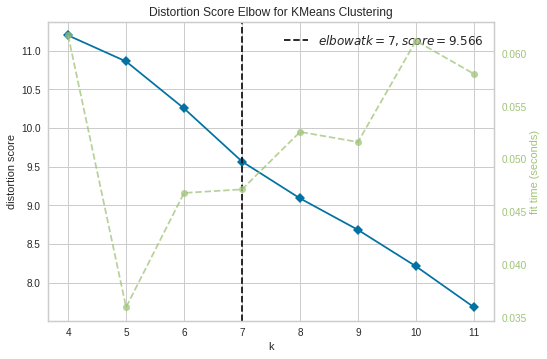

In [33]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,12))
visualizer.fit(toronto_grouped_clustering)
visualizer.show()

accordingly, the best value for k is 7

In [68]:
kclusters = 7 #number of cluster according to the elbow method

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 4, 3, 1, 1, 3, 1, 1, 1], dtype=int32)

In [76]:
neighborhoods_venues_sorted.drop(labels='Cluster Labels', axis=1, inplace=True) #To be used only if we do the clustering again

In [77]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_wiki


In [78]:
# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

In [79]:
toronto_merged.head()

,PostalCode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M3A,North York,Parkwoods,43.75188,-79.33036,3.0,Park,Food & Drink Shop,Pet Store,Event Space,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
1,M4A,North York,Victoria Village,43.73042,-79.31282,1.0,Pizza Place,Portuguese Restaurant,Intersection,French Restaurant,Coffee Shop,Park,Event Space,Falafel Restaurant,Ethiopian Restaurant,Farm
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65514,-79.36265,1.0,Coffee Shop,Bakery,Park,Theater,Breakfast Spot,Italian Restaurant,Café,Restaurant,Yoga Studio,Skating Rink
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72321,-79.45141,1.0,Clothing Store,Furniture / Home Store,Dessert Shop,Food Court,Sushi Restaurant,American Restaurant,Cosmetics Shop,Women's Store,Toy / Game Store,Coffee Shop
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66449,-79.39302,1.0,Coffee Shop,Clothing Store,Café,Boutique,Park,Concert Hall,Beer Bar,Cupcake Shop,French Restaurant,Steakhouse


In [80]:
#drop NaN rows
toronto_merged.dropna(inplace=True)

#transform cluster column in integers
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].apply(np.int64)

visualize results:

In [81]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)


# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Let's finally analyze the clusters

1. Cluster

In [82]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Scarborough,0,Fast Food Restaurant,Yoga Studio,Event Space,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant


2. Cluster

In [84]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,North York,1,Pizza Place,Portuguese Restaurant,Intersection,French Restaurant,Coffee Shop,Park,Event Space,Falafel Restaurant,Ethiopian Restaurant,Farm
2,Downtown Toronto,1,Coffee Shop,Bakery,Park,Theater,Breakfast Spot,Italian Restaurant,Café,Restaurant,Yoga Studio,Skating Rink
3,North York,1,Clothing Store,Furniture / Home Store,Dessert Shop,Food Court,Sushi Restaurant,American Restaurant,Cosmetics Shop,Women's Store,Toy / Game Store,Coffee Shop
4,Downtown Toronto,1,Coffee Shop,Clothing Store,Café,Boutique,Park,Concert Hall,Beer Bar,Cupcake Shop,French Restaurant,Steakhouse
7,North York,1,Coffee Shop,Bank,Beer Store,Sandwich Place,Restaurant,Italian Restaurant,Japanese Restaurant,Juice Bar,Supermarket,Chinese Restaurant
8,East York,1,Pizza Place,Brewery,Breakfast Spot,Athletics & Sports,Rock Climbing Spot,Café,Fast Food Restaurant,Soccer Stadium,Gastropub,Bank
9,Downtown Toronto,1,Clothing Store,Coffee Shop,Japanese Restaurant,Cosmetics Shop,Hotel,Bubble Tea Shop,Café,Sandwich Place,Electronics Store,Pizza Place
10,North York,1,Pizza Place,Grocery Store,Pub,Fast Food Restaurant,Latin American Restaurant,Sushi Restaurant,Gas Station,Japanese Restaurant,Italian Restaurant,Ice Cream Shop
11,Etobicoke,1,Pizza Place,Chinese Restaurant,Movie Theater,Distribution Center,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
12,Scarborough,1,Construction & Landscaping,Bar,Yoga Studio,Event Space,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Falafel Restaurant


3. Cluster

In [85]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
71,Scarborough,2,Pool,Yoga Studio,Ethiopian Restaurant,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space


4. Cluster

In [86]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,North York,3,Park,Food & Drink Shop,Pet Store,Event Space,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
5,Etobicoke,3,Pharmacy,Park,Café,Shopping Mall,Bank,Skating Rink,Grocery Store,Ethiopian Restaurant,Event Space,Falafel Restaurant
18,Scarborough,3,Park,Tea Room,Tennis Court,Construction & Landscaping,Dry Cleaner,Gym / Fitness Center,Electronics Store,Doner Restaurant,Donut Shop,Dumpling Restaurant
21,York,3,Park,Bakery,Beer Store,Women's Store,Sporting Goods Shop,Mexican Restaurant,Gym,Café,Bus Stop,Dumpling Restaurant
27,North York,3,Park,Bakery,Pharmacy,Chinese Restaurant,Residential Building (Apartment / Condo),Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dry Cleaner
31,West Toronto,3,Park,Bakery,Grocery Store,Café,Bank,Bus Stop,Diner,Bar,Music Venue,Coffee Shop
35,East York,3,Park,Convenience Store,Italian Restaurant,Farmers Market,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store
39,North York,3,Asian Restaurant,Flower Shop,Gas Station,Golf Driving Range,Park,Trail,Yoga Studio,Donut Shop,Dry Cleaner,Dumpling Restaurant
41,East Toronto,3,Discount Store,Theater,Business Service,Park,Other Great Outdoors,Grocery Store,Bus Stop,Bus Line,Electronics Store,Dry Cleaner
49,North York,3,Trail,Park,Basketball Court,Tennis Court,Bakery,Home Service,Playground,Fast Food Restaurant,Eastern European Restaurant,Doner Restaurant


5. Cluster

In [87]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,North York,4,Park,IT Services,Yoga Studio,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant,Event Space
45,North York,4,Park,Yoga Studio,Distribution Center,Doner Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant


6. Cluster

In [88]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,North York,5,Home Service,Business Service,Yoga Studio,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Event Space


7. Cluster

In [89]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 6, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Scarborough,6,Coffee Shop,Park,Business Service,Yoga Studio,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Ethiopian Restaurant
57,North York,6,Coffee Shop,Park,Nightclub,Café,Ethiopian Restaurant,Donut Shop,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store


The results are mitigated. Indeed, it appears that we basically have two main clusters (number 2 and 4). The cluster number 2 essentially contains restaurants, bars etc. whereas the number 4 essentially consists in parks, and other stores not selling food.

From those results, it can be inferred that no strong results are achieved and that several other variables may be taken into account as to establish a proper clustering (density of population, density of venues, schools, etc...). A lot of those data can be found only here: https://open.toronto.ca/